# Splash dynamics on a cone surface



## Documentation and Imports


Created on 27-07-21

Author: Valentin Laplaud

Formulas and graphs describing the dynamics of a drop splashing on a cone

In [1]:
# plotting stuff
import matplotlib as mpl
mpl.use('TkAgg')
%matplotlib inline

COLOR = 'white'
COLOR2 = 'black'

mpl.rcParams['text.color'] = COLOR
mpl.rcParams['axes.labelcolor'] = COLOR
mpl.rcParams['xtick.color'] = COLOR
mpl.rcParams['ytick.color'] = COLOR
mpl.rcParams['axes.edgecolor'] = COLOR

mpl.rcParams["figure.facecolor"] = COLOR2
mpl.rcParams["axes.facecolor"] = COLOR2
mpl.rcParams["savefig.facecolor"] = COLOR2

import matplotlib.pyplot as plt
from cycler import cycler


# numbers handling
import numpy as np
from numpy import pi
import pandas as pd

# signal processing 
from scipy.signal import savgol_filter, correlate, correlation_lags
from scipy.interpolate import interp1d

# images handling
from skimage import io
from skimage.filters import threshold_mean, gaussian, laplace, sobel
from skimage.measure import label, regionprops, regionprops_table
from skimage.util import invert
from skimage.morphology import binary_opening, binary_closing, remove_small_holes,binary_erosion
from skimage.color import rgb2gray, rgb2hsv
from skimage.segmentation import active_contour, morphological_geodesic_active_contour,morphological_chan_vese, checkerboard_level_set, inverse_gaussian_gradient
import cv2 as cv
import pims
import trackpy as tp

# to hide known warnings
import warnings
warnings.filterwarnings("ignore")

# General system functions
import os
import shutil
import sys

import time

# my functions
sys.path.append('../')
import VallapFunc as vf


## Analytical model

###  Cone geometry

In [2]:
""" For a specific cone, of diameter Rc and angle Alpha with the vertical, we compute :
the radius Ro of the original circle, 
the angle Beta of the sector removed from the circle, 
the fraction Fr of circle surface in the cone"""

def coneGeometry(Rcone,Alpha):
    # perimeter of cone 
    Pcone = 2*pi*Rcone # (in mm)

    # Cone Side length
    Lcone = Rcone/np.sin(Alpha)

    """ Unfolded cone as a cropped circle of radius Lcone """

    Rcircle = Lcone.copy()

    # Perimter of full circle
    Pcircle = 2*pi*Rcircle

    # Fraction of the circle remaining to form the cone
    Fr = Pcone/Pcircle # analytically Fr = sin(Alpha)

    # Angle of the removed circle part
    Beta = 2*pi*(1-Fr) # analytically Beta = 2*pi*(1-sin(Alpha))
        
    return(Rcircle,Beta,Fr)

### Drop impact characteristics

#### Adimensional numbers

In [3]:
### Parameters
V = 4 # [m/s] drop impact speed
L = 0.003 # [m] cone diameter
rho = 1000 # [kg/m3] water density
mu = 0.001 # [Pa.s] water viscosity
gamma = 0.07 # [N/m] water surface tension
g = 10 # [m/s²] gravity constant

### Adimensional numbers

# Reynolds (viscosity vs. intertia)
Re = rho*V*L/mu
print('Reynolds = ' + str(Re))

# Weber (capilarity vs. inertia)
We = rho*L*V**2/gamma
print('Weber = ' + str(We))

# Froude (gravity vs. intertia)
Fr = V/np.sqrt(g*L)
print('Froude = ' + str(Fr))

Reynolds = 12000.0
Weber = 685.7142857142857
Froude = 23.09401076758503


#### Localisation of points in drop and on cone

In [4]:
def PointsInSplash(R,Theta,Rc,Rd,Xd,Yd):
    # Points to evaluate in radial coord (R,Theta), Cone radius, Drop radius, drop center (Xd,Yd) 
    
    # For a set of points, returns a boolean vector telling if they are at the intersection of 
    # the cone and the drop, and thus in the splash
    
    ## Point in the cone 
    isInCone = R<Rc
    
    ## Point in the drop
    isInDrop = R**2 - 2*R*(Xd*np.cos(Theta)+Yd*np.sin(Theta)) + Xd**2 + Yd**2 < Rd**2
    
    return(isInCone,isInDrop)

#### Fall proba and volume fractions

##### Probability of the drop of radius Rd to fall at a distance r from the center of the cone of radius Rc

In [5]:

""" We consider the probability of falling in a stripe of width dr = 1% of Rc+Rd. 
The center of the drop can fall short of the cone but still have a partial splash""" 

# P(r) = 2*pi*r*dr / pi*(Rc+Rd)²  with dr = 1/100*(Rc+Rd)  thus P(r) = 2*r/(100*(Rc+Rd)) = r/(50*(Rc+Rd))

def Proba(r,Rd,Rc):
    P =  r/50/(Rc+Rd)*100 # in %
    return(P)




##### Fraction of the drop volume impacting the cone

In [6]:
""" Fraction of the drop volume impacting the cone for a impact at distance r from the center """

## The computation is done using the formula for the intersection of a sphere and a cylinder 

def volFrac(r,Rd,Rc):
    F = np.empty(len(r))
    for rr,ir in zip(r,range(len(r))):
        if rr+Rd<=Rc:
            F[ir] = 1
        else:                
            F[ir] = vf.interVolSC(Rd,Rc,rr)/(4/3*pi*Rd**3)
    return(F*100)


##### Fraction of splash/drop in the jet

In [7]:
""" Fraction of the impacting volume forming the jet (for r > Rcircle)"""

# The impact point (I) of the drop is along the bisecant of the removed sector, 
# at a distance r of the center of the circle (C).
# For certain angles, a straight trajectory originating in (I), with an angle Gamma, can intersect the 
# border of the removed sector at a point (M). (M) is at a distance rM < Rcircle from the center (C). 
# For a point (M) at rM = Rcircle, the angle GammaMax defines the fraction of the splash that ends up 
# in the jet

def splashFracJet(r,Rcone,Rdrop,Alpha): # returns the fraction of a splash in the jet, for an impact at distance r, 
    # on a cone of angle Alpha and radius Rcone
    
    Rcircle,Beta = coneGeometry(Rcone,Alpha)[0:2]
    
    FJ = np.empty(len(r))
    for rr,ir in zip(r,range(len(r))):
    
        if rr>Rcone:
            
            jetAngle = 2*np.arctan((np.sin(Beta/2)*Rcircle)/(rr+np.cos(Beta/2)*Rcircle)) 
            # Angle between the border of the removed sector and the drop center, 
            # corresponds to the part of the splash ending up in the jet



            splashAngle = 2*np.arctan2(Rcone*np.sin(np.sin(Alpha)*np.arccos((Rdrop**2-Rcone**2-rr**2)/(2*rr*Rcone))),
                                      rr-Rcone*np.cos(np.sin(Alpha)*np.arccos((Rdrop**2-Rcone**2-rr**2)/(2*rr*Rcone))))
            # angle between the interection points of drop and cone, defining the angle of the jet

            FJ[ir] = np.min([jetAngle/splashAngle, 1])
        
        else:
            """"Needs to be done if there is a geometrical solution """""
    return(FJ*100)


""" Drop volume fraction in the splash (for r > Rcircle)"""

def DropFrac(r,Rcone,Rdrop,Alpha):
    
    Fimpact = volFrac(r,Rdrop,Rcone)/100 # fraction of the drop to impact
    Fjet = splashFracJet(r,Rcone,Rdrop,Alpha)/100 # fraction of the impacting volume in the jet
    
    
    DF = Fimpact*Fjet
    
    return(DF*100)

##### Numerical resolution of fraction of volume in the jet

###### In 2D

In [8]:
def JetVolFrac2D(coneR,Alpha,dropR,Xdrops,nptmesh):
    # computes the fraction of the volume impacting the cone ending up in the jet 
    # as a function of the cone radius and vertical angle Alpha, of the drop radius and position 
    # and of the distance r between cone and drop center. 
    # The number of point along one side of the mesh is a parameter

    # We consider a cone centered on (0,0) and a drop with center in position (Xdrop,0), 
    # Xdrop corresponds to the distance between the centers

    # Fraction of splash in jet
    Frac = np.empty(len(Xdrops))

    ### Cone in circle config
    circleR = coneGeometry(coneR,Alpha)[0] # Cropped circle radius
    Beta = coneGeometry(coneR,Alpha)[1] # angle of sector to remove

    for Xdrop,ir in zip(Xdrops,range(len(Xdrops))):

        ### Drop
        Ydrop = 0
        Adrop,Rdrop = vf.ToCirc(Xdrop,Ydrop,angle='rad') # Drop center (cone config) in radial 
        # centered on the cone
        XdCi,YdCi = vf.ToCart(Adrop,Rdrop/np.sin(Alpha)) # Drop center (circle config)
        AdCi,RdCi = vf.ToCirc(XdCi,YdCi,angle = 'rad') # Drop center in radial centered 
        # on the cone (circle config)

        ### Mesh of points in the splash
        Xmin, Xmax, Ymin, Ymax = (np.min([-coneR,Xdrop-dropR]),np.max([coneR,Xdrop+coneR]),
                                         np.min([-coneR,Ydrop-dropR]), np.max([coneR,Ydrop+coneR]))
        Xs = np.linspace(Xmin, Xmax, nptmesh)
        Ys = np.linspace(Ymin, Ymax, nptmesh)
        Xgrid,Ygrid = np.meshgrid(Xs,Ys) # mesh points in carthesian (cone config)
        Xgrid = Xgrid.flatten()
        Ygrid = Ygrid.flatten()
        Agrid,Rgrid = vf.ToCirc(Xgrid,Ygrid) # mesh points in polar (cone config)

        # points in the impacting volume (cone config)
        isCone,isDrop = PointsInSplash(Rgrid,Agrid,coneR,dropR,Xdrop,Ydrop) 
        Xsplash = Xgrid[isCone&isDrop]
        Ysplash = Ygrid[isCone&isDrop]
        Asplash, Rsplash = vf.ToCirc(Xsplash,Ysplash, angle = 'rad') 
        # circe config
        XsplashCi, YsplashCi = vf.ToCart((Asplash-AdCi)*np.sin(Alpha)+AdCi,Rsplash/np.sin(Alpha),angle='rad')

        ### Geometry of the removed sector to form a cone        
        T1 = np.mod(-Beta/2,2*pi)
        T2 = np.mod(Beta/2,2*pi)
        if T1>T2:
            Ts = np.linspace(np.mod(T1+pi,2*pi),np.mod(T2+pi,2*pi),20) - pi        
        else:                
            Ts = np.linspace(T1,T2,20)


        ### Trajectories of each point and sector crossing
        pts = np.linspace(0,3,5)
        Xpts = np.empty((len(pts),len(XsplashCi)))
        Ypts = np.empty((len(pts),len(YsplashCi)))
        inter = np.empty(len(YsplashCi))
        Xint = np.empty((len(pts),len(XsplashCi)))
        Yint = np.empty((len(pts),len(YsplashCi)))
        # equations for the lines of the sector borders (y = c12*x)
        c1 = np.tan(Adrop+pi-Beta/2)
        c2 = np.tan(Adrop-pi+Beta/2)
        for (x,y,i) in zip(XsplashCi, YsplashCi, range(len(XsplashCi))):
            Xpts[:,i] = x + pts*(x-XdCi)/np.sqrt(vf.dist(x,y,XdCi,YdCi))
            Ypts[:,i] = y + pts*(y-YdCi)/np.sqrt(vf.dist(x,y,XdCi,YdCi))
            # equation for the line along the trajectory (y = a*x + b)
            a = (Ypts[1,i] - YdCi)/(Xpts[1,i] - XdCi)
            b = (Xpts[1,i]*YdCi - Ypts[1,i]*XdCi)/(Xpts[1,i] - XdCi) 
            # intersection points
            xi1 = b/(c1-a)
            xi2 = b/(c2-a)
            Xint[:,i] = xi1
            Yint[:,i] = c1*xi1
            # intersection if Ri1 or Ri2 is >0 and <Rcircle
            inter[i] = (((xi1/np.cos(Adrop+pi-Beta/2)>=0)&(xi1/np.cos(Adrop+pi-Beta/2)<circleR)&(Xpts[1,i]<XdCi)) | 
                        ((xi2/np.cos(Adrop-pi+Beta/2)>=0)&(xi2/np.cos(Adrop-pi+Beta/2)<circleR)&(Xpts[1,i]<XdCi)))

        Frac[ir] = np.sum(inter)/len(inter)

    return(Frac*100)

###### Sphere height

In [9]:
def SphereH(R,X,Y,Xs):
    # Compute the height of a column at (X,Y) in a sphere of radius R centered on (Xs,0,0)
    
    H = 2*np.sqrt(R**2-(X-Xs)**2-Y**2)
    
    H[np.isnan(H)] = 0
    
    return(H)

###### In 3D

In [10]:
def JetVolFrac3D(coneR,Alpha,dropR,Xdrops,nptmesh):
    # computes the fraction of the volume impacting the cone ending up in the jet 
    # as a function of the cone radius and vertical angle Alpha, of the drop radius and position 
    # and of the distance r between cone and drop center. 
    # The number of point along one side of the mesh is a parameter

    # We consider a cone centered on (0,0) and a drop with center in position (Xdrop,0), 
    # Xdrop corresponds to the distance between the centers

    # Fraction of splash in jet
    Frac = np.empty(len(Xdrops))

    ### Cone in circle config
    circleR = coneGeometry(coneR,Alpha)[0] # Cropped circle radius
    Beta = coneGeometry(coneR,Alpha)[1] # angle of sector to remove

    for Xdrop,ir in zip(Xdrops,range(len(Xdrops))):

        ### Drop
        Ydrop = 0
        Adrop,Rdrop = vf.ToCirc(Xdrop,Ydrop,angle='rad') # Drop center (cone config) in radial 
        # centered on the cone
        XdCi,YdCi = vf.ToCart(Adrop,Rdrop/np.sin(Alpha)) # Drop center (circle config)
        AdCi,RdCi = vf.ToCirc(XdCi,YdCi,angle = 'rad') # Drop center in radial centered 
        # on the cone (circle config)

        ### Mesh of points in the splash
        Xmin, Xmax, Ymin, Ymax = (np.min([-coneR,Xdrop-dropR]),np.max([coneR,Xdrop+coneR]),
                                         np.min([-coneR,Ydrop-dropR]), np.max([coneR,Ydrop+coneR]))
        Xs = np.linspace(Xmin, Xmax, nptmesh)
        Ys = np.linspace(Ymin, Ymax, nptmesh)
        Xgrid,Ygrid = np.meshgrid(Xs,Ys) # mesh points in carthesian (cone config)
        Xgrid = Xgrid.flatten()
        Ygrid = Ygrid.flatten()
        Agrid,Rgrid = vf.ToCirc(Xgrid,Ygrid) # mesh points in polar (cone config)

        # points in the impacting volume (cone config)
        isCone,isDrop = PointsInSplash(Rgrid,Agrid,coneR,dropR,Xdrop,Ydrop) 
        Xsplash = Xgrid[isCone&isDrop]
        Ysplash = Ygrid[isCone&isDrop]
        Hsplash = SphereH(dropR,Xsplash,Ysplash,Xdrop)
        Asplash, Rsplash = vf.ToCirc(Xsplash,Ysplash, angle = 'rad') 
        # circe config
        XsplashCi, YsplashCi = vf.ToCart((Asplash-AdCi)*np.sin(Alpha)+AdCi,Rsplash/np.sin(Alpha),angle='rad')

        ### Geometry of the removed sector to form a cone        
        T1 = np.mod(-Beta/2,2*pi)
        T2 = np.mod(Beta/2,2*pi)
        if T1>T2:
            Ts = np.linspace(np.mod(T1+pi,2*pi),np.mod(T2+pi,2*pi),20) - pi        
        else:                
            Ts = np.linspace(T1,T2,20)


        ### Trajectories of each point and sector crossing
        pts = np.linspace(0,3,5)
        Xpts = np.empty((len(pts),len(XsplashCi)))
        Ypts = np.empty((len(pts),len(YsplashCi)))
        inter = np.empty(len(YsplashCi))
        Xint = np.empty((len(pts),len(XsplashCi)))
        Yint = np.empty((len(pts),len(YsplashCi)))
        # equations for the lines of the sector borders (y = c12*x)
        c1 = np.tan(Adrop+pi-Beta/2)
        c2 = np.tan(Adrop-pi+Beta/2)
        for (x,y,i) in zip(XsplashCi, YsplashCi, range(len(XsplashCi))):
            Xpts[:,i] = x + pts*(x-XdCi)/np.sqrt(vf.dist(x,y,XdCi,YdCi))
            Ypts[:,i] = y + pts*(y-YdCi)/np.sqrt(vf.dist(x,y,XdCi,YdCi))
            # equation for the line along the trajectory (y = a*x + b)
            a = (Ypts[1,i] - YdCi)/(Xpts[1,i] - XdCi)
            b = (Xpts[1,i]*YdCi - Ypts[1,i]*XdCi)/(Xpts[1,i] - XdCi) 
            # intersection points
            xi1 = b/(c1-a)
            xi2 = b/(c2-a)
            Xint[:,i] = xi1
            Yint[:,i] = c1*xi1
            # intersection if Ri1 or Ri2 is >0 and <Rcircle
            inter[i] = (((xi1/np.cos(Adrop+pi-Beta/2)>=0)&(xi1/np.cos(Adrop+pi-Beta/2)<circleR)&(Xpts[1,i]<XdCi)) | 
                        ((xi2/np.cos(Adrop-pi+Beta/2)>=0)&(xi2/np.cos(Adrop-pi+Beta/2)<circleR)&(Xpts[1,i]<XdCi)))

        Frac[ir] = np.sum(Hsplash[inter.astype(bool)])/np.sum(Hsplash)
    return(Frac*100)

### Predictions on droplets size distributions

In [11]:
""" Ejected droplets can come either from the rim of the splash, or from the jet. We can compare the 
volume fraction present in the splash to the one in the jet to have the ratio between the distributions 
of big droplet from the jet and small droplets from the splash."""





' Ejected droplets can come either from the rim of the splash, or from the jet. We can compare the \nvolume fraction present in the splash to the one in the jet to have the ratio between the distributions \nof big droplet from the jet and small droplets from the splash.'

### Trajectories transformation

In [12]:

def makeTraj(Xo,Yo,angles,npts,Xc,Yc,Rc):
    
    X = []
    Y = []

    for a in angles:
        X = np.append(X,Xo + np.linspace(0,5*Rc,npts)*np.cos(a))
        Y = np.append(Y,Yo + np.linspace(0,5*Rc,npts)*np.sin(a))
        
    insidePts = vf.dist(X,Y,Xc,Yc) < Rc
    
    X = X[insidePts]
    Y = Y[insidePts]
    

    
    return(X,Y)

def Cone2Circle(X,Y,Alpha,Ad):
    # (X,Y) points to transform, Alpha angle of the cone, Ad angle of the drop center position (cone config)
    A,R = vf.ToCirc(X,Y,angle = 'rad')
    Xnew,Ynew = vf.ToCart((A-Ad)*np.sin(Alpha)+Ad,R/np.sin(Alpha),angle = 'rad')

    return(Xnew,Ynew)

def Circle2Cone(X,Y,Alpha,Ad): 
    # (X,Y) points to transform, Alpha angle of the cone, Ad angle of the drop center position (circle config)
    A,R = vf.ToCirc(X,Y,angle = 'rad')
    Xnew,Ynew = vf.ToCart((A-Ad)/np.sin(Alpha)+Ad,R*np.sin(Alpha),angle = 'rad')
    
    return(Xnew,Ynew)

def ComputeTransfo(Xc,Yc,Rcircle,Alpha,Xi,Yi,angles, **kwargs):
    # Circle center (Xc,Yc) & radius (Rcircle), cone angle (Alpha), impact coordinates (Xi,Yi),
    # points to transform (X,Y) 

        Animation = False
        P = ''
        Tt = ''
        
        for key, value in kwargs.items(): 
            if key == 'animation':
                Animation = value  
            elif key == 'path':
                P = value  
            elif key == 'title':
                Tt = value  
            else:
                print('Unknown key : ' + key + '. Kwarg ignored.')

        if (Animation) & (P==''):
            print('If Animation = True, kwarg "path" must have a value')
            return

        if (Animation) & (Tt==''):
            print('If Animation = True, kwarg "title" must have a value')
            return
            
        X,Y = makeTraj(Xi,Yi,angles,125,Xc,Yc,Rcircle)    
            
        Rcone = Rcircle*np.sin(Alpha) # cone radius
        Beta = coneGeometry(Rcone,Alpha)[1] # angle of sector to remove
        Fr = coneGeometry(Rcone,Alpha)[2] # fraction of circle remaining to form the cone

        """ Alignement on (0,0) """

        alXi = Xi - Xc
        alYi = Yi - Yc

        alX = X - Xc
        alY = Y - Yc
                
        OffA = vf.ToCirc(Xc-Xi,Yc-Yi,angle = 'rad')[0] #angle between impact and center

        """ Conversion to circular coordinates """

        Ti,Ri =  vf.ToCirc(alXi,alYi,angle='rad')

        T,R =  vf.ToCirc(alX,alY,angle='rad')
        T = np.mod(T,2*pi)
        
        """ Removed sector to form a cone """
        
        T1 = np.mod(OffA - Beta/2,2*pi)
        T2 = np.mod(OffA + Beta/2,2*pi)

     
        if T1>T2:
            Ts = np.linspace(np.mod(T1+pi,2*pi),np.mod(T2+pi,2*pi),20) - pi
            goodPts = ((T < T1) & (T > T2))            
        else:                
            Ts = np.linspace(T1,T2,20)
            goodPts = ((T < T1) | (T > T2))
            
        alX,alY = vf.ToCart(T[goodPts],R[goodPts],angle='rad') 
                
        sectorT = np.append(np.append([T1],Ts),[T2])
        sectorR = np.append(np.append([0],Rcircle*np.ones(20)),[0])
        
        sectorX,sectorY = vf.ToCart(sectorT,sectorR,angle = 'rad')
        
        # Impact point
        coneTi = Ti
        coneRi = Ri*Fr
        
        coneXi,coneYi = vf.ToCart(coneTi,coneRi,angle='rad')
        coneZi = coneRi*np.cos(Alpha)
        
        # Trajectories
        
        coneT = np.mod(T[goodPts]-Ti,2*pi)
        coneT[coneT>pi] = coneT[coneT>pi]-2*pi
        coneT = coneT/Fr + Ti
        
        coneR = R[goodPts]*Fr
        coneZ = coneR*np.cos(Alpha)
        
        coneX,coneY = vf.ToCart(coneT,coneR,angle='rad')
        
        """ Transformation from circle to cone """
        
        if Animation:
            """ Circle to cone animation """            
            
            for i in range(0,101):
                fig0= plt.figure(dpi = 500)
                fig0.suptitle(Tt)                
                
                ax01 = fig0.add_subplot(1,2,2) 
                ax02 = fig0.add_subplot(1,2,1,projection='3d')                
                
                ax01.set_aspect('equal', adjustable='box')
                ax01.set_xlim([-Rcircle*1.1, Rcircle*1.1] )
                ax01.set_ylim([-Rcircle*1.1, Rcircle*1.1])
                ax01.set_xticks([])
                ax01.set_yticks([])
                ax01.set_title('Cone projection on (X,Y) plane')
                
                ax02.set_xticks([])
                ax02.set_yticks([])
                ax02.set_zticks([])
                ax02.set_xlim([-Rcircle*1.1, Rcircle*1.1])
                ax02.set_ylim([-Rcircle*1.1, Rcircle*1.1])
                ax02.set_zlim([0, Rcircle*np.cos(Alpha)])
                ax02.set_title('Cone folding in 3D')
                
                coneTi = Ti
                coneRi = Ri*(1-(1-Fr)*i/100)

                coneXi,coneYi = vf.ToCart(coneTi,coneRi,angle='rad')
                coneZi = coneRi*np.cos(Alpha)*i/100

                # Trajectories
                        

                coneT = np.mod(T[goodPts]-Ti,2*pi)
                coneT[coneT>pi] = coneT[coneT>pi]-2*pi
                coneT = coneT/(1-(1-Fr)*i/100) + Ti

                coneR = R[goodPts]*(1-(1-Fr)*i/100)
                coneZ = coneR*np.cos(Alpha)*i/100

                coneX,coneY = vf.ToCart(coneT,coneR,angle='rad')
            
                tx = np.linspace(0,2*pi,1000)
                
                Rcircle*(1-(1-Fr)*i/100)*np.cos(tx),Rcone*np.cos(Alpha)*i/100
            
                circleX = Rcircle*(1-(1-Fr)*i/100)*np.cos(tx)
                circleY = Rcircle*(1-(1-Fr)*i/100)*np.sin(tx)
                circleZ = np.max(coneZ)*np.ones(len(circleX))
                
                
                T1 = np.mod(OffA - Beta/2*(100-i)/100,2*pi)
                T2 = np.mod(OffA + Beta/2*(100-i)/100,2*pi)
                
                if T1>T2:
                    Ts = np.linspace(np.mod(T1+pi,2*pi),np.mod(T2+pi,2*pi),20) - pi
                            
                else:                
                    Ts = np.linspace(T1,T2,20)
            
                sectorT = np.append(np.append([T1],Ts),[T2])
                sectorR = np.append(np.append([0],Rcircle*(1-(1-Fr)*i/100*np.ones(len(Ts)))),[0])
                sectorZ = sectorR*np.cos(Alpha)*i/100
                
                sectorX,sectorY = vf.ToCart(sectorT,sectorR,angle='rad')
            
                ax01.plot(coneX,coneY,'c.',ms=0.5)
                ax01.plot(coneXi,coneYi,'xr',ms = 2)
                ax01.plot(circleX,circleY,'go',ms=1.5)
                ax01.plot(sectorX,sectorY,'m--',lw=1)
                ax01.plot(0,0,'g*')
                
                ax02.plot3D(coneXi,coneYi,coneZi,'xr',ms = 2)
                ax02.plot3D(coneX,coneY,coneZ,'c.',ms=0.5)
                ax02.plot3D(circleX,circleY,circleZ,'go',ms=1.5)
                ax02.plot3D(sectorX,sectorY,sectorZ,'m--',lw=1)
                ax02.plot3D(0,0,0,'g*')
                
                fig0.tight_layout()
                fig0.savefig(P + str(i) + '.tif' )
                plt.close()
        
        #return(fig,[ax1,ax2,ax3,ax4])
        return(alX,alY,alXi,alYi,sectorX,sectorY,Rcircle,OffA,Rcone,coneX,coneY,coneXi,coneYi)

## Mega cone experiments

### Tracking 

In [13]:
def Track(P,StackList,SD,Scale,FPS):

    SD = SD.loc[StackList]
    
    TD = pd.DataFrame(data=None)
    
    if not os.path.exists(P + '\\Tracking'):
            os.mkdir(P + '\\Tracking') # create global folder 
    
    if not os.path.exists(P + '\\Trajectories'):
            os.mkdir(P + '\\Trajectories') # create global folder  
    
    for s in StackList:
        
        if not os.path.exists(P + '\\Tracking\\' + s):
            os.mkdir(P + '\\Tracking\\' + s) # create folder 
        
        if not os.path.exists(P + '\\Trajectories\\' + s):
            os.mkdir(P + '\\Trajectories\\' + s) # create folder 
        
        Stack = io.imread(P + '\\' + s + '_Processed_Cut.tif') # get the tiff stack
        
        print('Tracking for video : ' + s)
        # Drop position
        Xd = SD.loc[s,'DropXc']
        Yd = SD.loc[s,'DropYc']
        Rd = SD.loc[s,'DropDiam']/2*Scale
        # Target position
        Xt = SD.loc[s,'TargetXc']
        Yt = SD.loc[s,'TargetYc']
        Rt = SD.loc[s,'TargetDiam']/2*Scale
        
        # Tracking
        frames = pims.open(P + '\\' + s + '_Processed_Cut.tif')
        tp.quiet()
        f = tp.batch(frames, 11, invert=False, minmass=500) # 15px size estimate
        f['CenterDist'] = vf.dist(f['x'].values,f['y'].values,Xt,Yt)
        f = f.loc[f['CenterDist']<Rt]

  #      for i in range(len(frames)):
  #          fig, ax = plt.subplots(dpi=250)
  #          fig.suptitle(s + '_img' + str(i))
   #         tp.annotate(f[f['frame']==i], frames[i])
    #        fig.savefig(P + '\\Tracking\\' + s + '\\' + str(i) + '.tif')
    #        plt.close()

#        @tp.predict.predictor
#        def predict(t1, particle):
#            velocity = 3*(np.array(((particle.pos[0]-Xd),(particle.pos[1]-Yd)))
#                          /np.sqrt(np.square(particle.pos[0]-Xd)+np.square(particle.pos[1]-Yd))) # Going away from target
#            return particle.pos + velocity * (t1 - particle.t)
        
        t = tp.link(f, 5, memory=1) # px max from the prediction, images memory 
        
        
        t = tp.filter_stubs(t, 15) # remove trajectories with less than 10 images (1 ms)
             
        particleList = np.unique(t['particle'].values)
        
        for p in particleList:
            trajP = t[t['particle'] == p]
            X = trajP['x'].values
            Y = trajP['y'].values
            length = vf.dist(X[len(X)-1],Y[len(X)-1],
                             X[0],Y[0])
            if length>30:
                t.loc[t['particle'] ==p,'lengthOK'] = True
            else:
                t.loc[t['particle'] ==p,'lengthOK'] = False
                
        
        t['Splash'] = s
        
        OffC = SD.loc[s,'OffCentering_pcDropDiam']
       
        
        TD = TD.append(t[t['lengthOK']], ignore_index=True)
        TD.loc[TD['Splash'] == s,'OffC'] = OffC
        
        fig,ax = plt.subplots(dpi=300)
        absc = np.linspace(0,2*pi,1000)
        ax.plot(Xt,Yt,'.g',ms=2)
        ax.plot(Xt+Rt*np.cos(absc),Yt+Rt*np.sin(absc),'--g',lw=0.5)
        ax.plot(Xd,Yd,'.r',ms=2)
        ax.plot(Xd+Rd*np.cos(absc),Yd+Rd*np.sin(absc),'--r',lw=0.5)
        tp.plot_traj(t[t['lengthOK']],ax = ax,plot_style={"linewidth": 0.6, "linestyle":'--'})
        ax.set_aspect('equal', adjustable='box')
        fig.suptitle(s)
        fig.savefig(P + '\\Trajectories\\' + s + '.tif')
        #plt.close()
        plt.show()
        
        for i in range(len(Stack)-1):
            fig0, ax0 = plt.subplots(dpi=250)
            plt.imshow(Stack[i],cmap='gray')
            xl = ax0.get_xlim()
            yl = ax0.get_ylim()
            if not t.loc[(t['frame']<i) & t['lengthOK']].empty:
                tp.plot_traj(t.loc[(t['frame']<i) & t['lengthOK']], ax = ax0)
            ax0.set_xlim(xl)
            ax0.set_ylim(yl)
            fig0.savefig(P + '\\Trajectories\\' + s + '\\' + str(i) + '.tif')
            plt.close()
        

    return(SD,TD)
        

### Plotting tracks

In [14]:
def plotTrackModel(SD,TD,StackList,ConeAngles,P):
    
    for a,s in zip(ConeAngles,StackList):
        
        # Positions of cone center
        Xc = SD.loc[s,'TargetXc']
        Yc = SD.loc[s,'TargetYc']
        
        # radius of the original circle, and angle of the cone
        Rcircle = SD.loc[s,'TargetDiam']/2*Scale210721/np.sin(a)
        Alpha = a
        
        # Position of drop impact on the cone
        Xd = SD.loc[s,'DropXc'] - Xc
        Yd = SD.loc[s,'DropYc'] - Yc
        
        # Position of drop impact on the cone in cilyndrical coordinate centered on the cone
        Ad,Rd = vf.ToCirc(Xd,Yd)

        # position of drop impact on the original circle (angle doesn't change as the impact is the 0° reference)
        Xi,Yi = vf.ToCart(Ad,Rd/np.sin(a))
        
        # # position of drop impact on the original circle in carthésian coordinates
        Xi = Xi 
        Yi = Yi 
        
        # Trajectories for stack s
        Trajs = TD[TD['Splash'] == s]
        
        # list of detected particles
        partList = np.unique(Trajs['particle'].values)
        
        # angles of the trajectories starting point
        angles = [];   
        
        # figure or the representations
        fig1, [ax1,ax2] = plt.subplots(ncols=2, dpi=300)
        
        tx = np.linspace(0,2*pi,100)
        
        ax1.set_title('Trajectories on the cone')
        ax1.set_aspect('equal', adjustable='box') 
        ax1.plot(0,0,'g*')
        ax1.plot(Rcircle*np.sin(a)*np.cos(tx),Rcircle*np.sin(a)*np.sin(tx),'g-') 
        ax1.plot(Xd,Yd,'r*')
        
        ax2.set_title('Trajectories on the flat unfolded circle')
        ax2.set_aspect('equal', adjustable='box') 
        ax2.plot(0,0,'g*')
        ax2.plot(Rcircle*np.cos(tx),Rcircle*np.sin(tx),'g-') 
        ax2.plot(Xi,Yi,'r*')
        
        for p in partList:       
            
            # trajectory on the cone for particle p
            Xp = Trajs.loc[Trajs['particle'] == p,'x'].values - Xc
            Yp = Trajs.loc[Trajs['particle'] == p,'y'].values - Yc 
            
            # plotting
            ax1.plot(Xp,Yp,'--',lw=1)     
            
            # Cylindrical coordinate of the trajectory on the cone
            A,R = vf.ToCirc(Xp,Yp)
            
            
            # coordinates on the original circle
            Ashift = A-Ad
            Ashift[Ashift>pi] = np.mod(Ashift[Ashift>pi],pi) - pi
            
            Acircle = Ashift*np.sin(a) + Ad

            Xpc,Ypc = vf.ToCart(Acircle,R/np.sin(a))
            
            # plotting
            ax2.plot(Xpc,Ypc,'--',lw=1) 
            
            # Angle of this trajectory            
            angles = np.append(angles,vf.ToCirc(Xpc[0]-Xi,
                                                Ypc[0]-Xi,angle='rad')[0])           
        
        fig1.savefig(P + '\\' + s + '_CircleTraj.tif')
        #plt.close(fig1)
        
        fig, ax = ComputeTransfo(Xc,Yc,Rcircle,Alpha,Xi,Yi,angles)
        fig.suptitle('Trajectories on the cone for ' + s)
        
        tp.plot_traj(Trajs,ax = ax[3],plot_style={"linewidth": 0.6, "linestyle":'--'})
        
        fig.tight_layout()
        fig.savefig(P + '\\' + s + '_Model.tif')
        
        return
        
    
    

## Run tracking

### Data details

### Loading

### Compute trajecories

### Compare with theory

## Plots

In [15]:
savepath = r'D:\Users\laplaud\Desktop\PostDoc\Data\SplashCups\Model\Images'

### Numerical values & Plots 

#### Representations

##### Analytical circle transformation

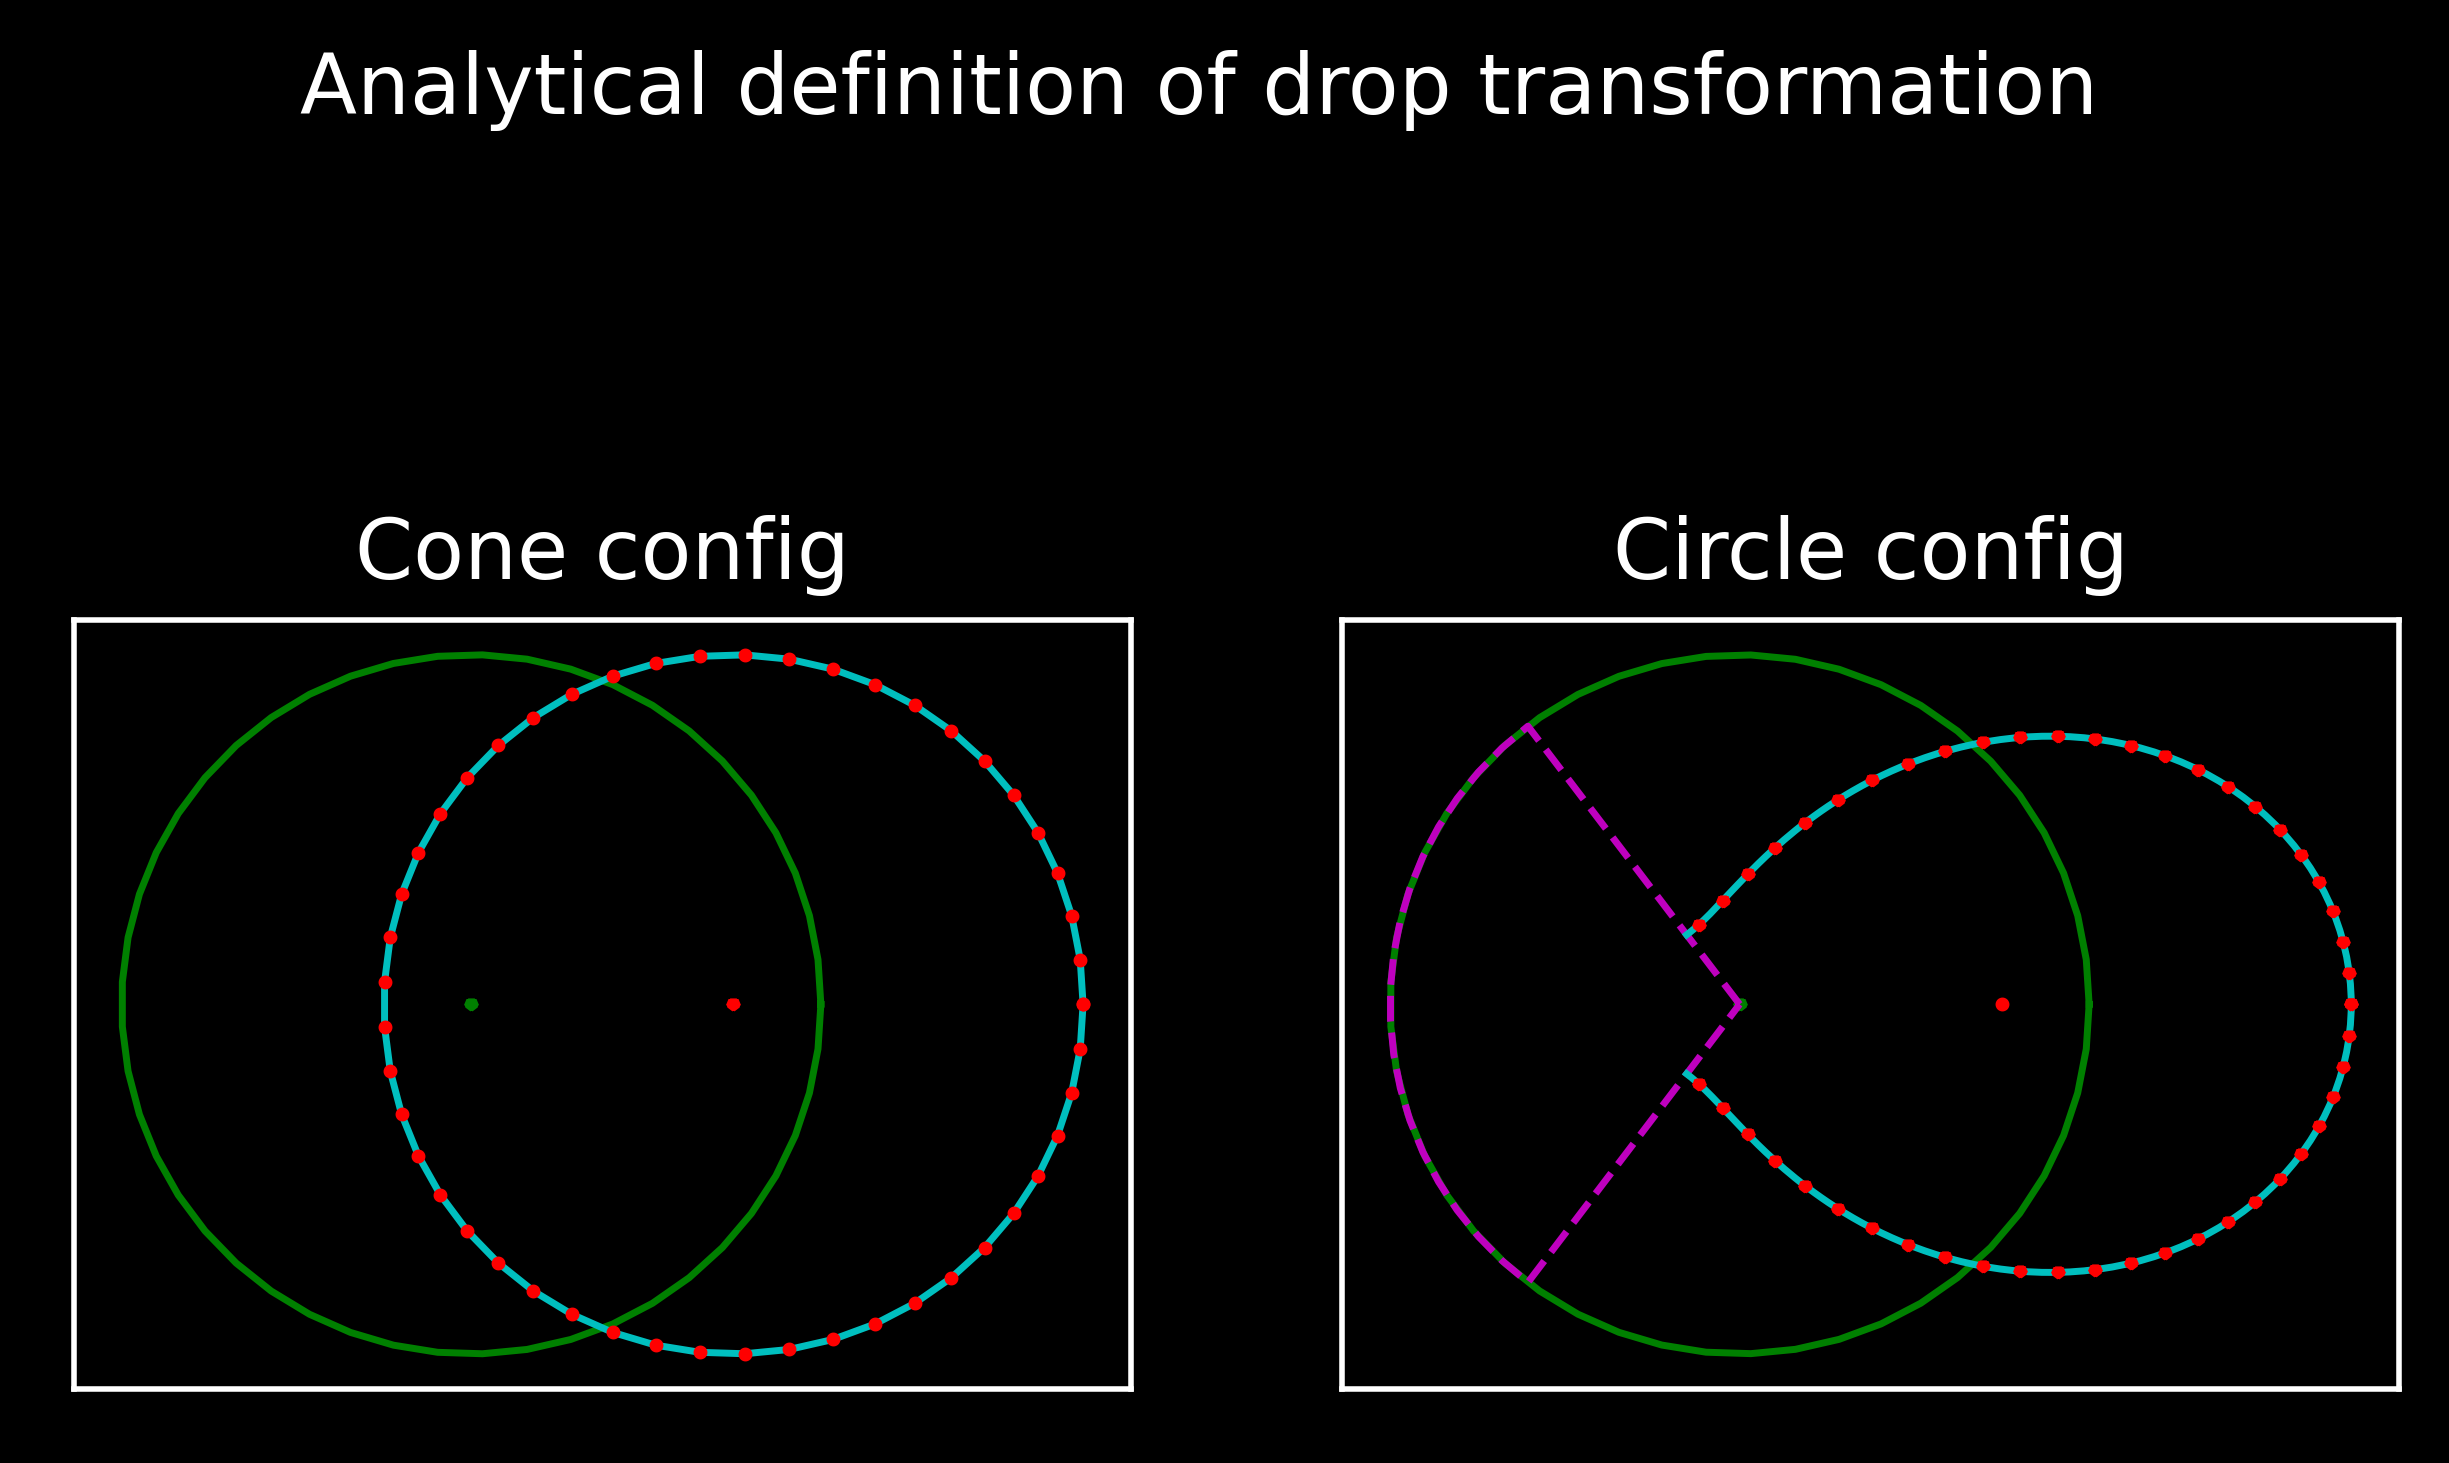

In [55]:
tx = np.linspace(0,2*pi,50)

### Cone
Xc = 0 # Cone center X always 0
Yc = 0 # Cone center Y always 0
coneR = 4 # Cone radius
Alpha = pi/4 # Cone vertical angle
circleR = coneGeometry(coneR,Alpha)[0] # Cropped circle radius
Beta = coneGeometry(coneR,Alpha)[1] # angle of sector to remove

### Drop
Xdrop = 3 # Drop center X (in cone configuration)
Ydrop = 0 # Drop denter Y (in cone configuration)
dropR = 4 # Drop radius (cone config)
Xdrops = Xdrop + dropR*np.cos(tx) # Drawing drop in cone config (X)
Ydrops = Ydrop + dropR*np.sin(tx) # Drawing drop in cone config (Y)
Adrop,Rdrop = vf.ToCirc(Xdrop,Ydrop,angle='rad') # Drop center (cone config) in radial 
# centered on the cone
Adrops, Rdrops = vf.ToCirc(Xdrops,Ydrops,angle='rad') # Drop drawing (cone config) in radial 
# centered on the cone
XdCi,YdCi = vf.ToCart(Adrop,Rdrop/np.sin(Alpha)) # Drop center (circle config)
XdCi = XdCi # Recentering X drop (circle config) in carthesian
YdCi = YdCi # Recentering Y drop (circle config) in carthesian
AdCi,RdCi = vf.ToCirc(XdCi,YdCi,angle = 'rad') # Drop center in radial centered 
# on the cone (circle config)
XdCis, YdCis = vf.ToCart((Adrops-AdCi)*np.sin(Alpha)+AdCi,Rdrops/np.sin(Alpha),angle='rad') # drop drawing 
# (circle config) in carthesian

### Removed sector to form a cone 
        
T1 = np.pi-Beta/2
T2 = np.pi+Beta/2

if T1>T2:
    Ts = np.linspace(np.mod(T1+pi,2*pi),np.mod(T2+pi,2*pi),20) - pi        
else:                
    Ts = np.linspace(T1,T2,20)

sectorT = np.append(np.append([T1],Ts),[T2])
sectorR = np.append(np.append([0],circleR*np.ones(20)),[0])

sectorX,sectorY = vf.ToCart(sectorT,sectorR,angle = 'rad')

### Anaytical drop equation in circle config

if Xdrop > dropR:
    ThetaBorder = np.sin(Alpha)*np.arcsin(dropR/Xdrop)
    Theta = np.linspace(-ThetaBorder,ThetaBorder,200)
    R = (Xdrop*np.cos(np.divide(Theta0,np.sin(Alpha))) - np.sqrt(dropR**2-Xdrop**2*np.sin(np.divide(Theta0,np.sin(Alpha)))**2))/(np.sin(Alpha))
    #R2 = (Xdrop*np.cos(np.divide(Theta0,np.sin(Alpha))) - np.sqrt(dropR**2-Xdrop**2*np.sin(np.divide(Theta0,np.sin(Alpha)))**2))/(np.sin(Alpha))
    #Theta = np.concatenate((Theta0, np.flip(Theta0)))
    #R = np.concatenate((R1, R2))
else:
    ThetaBorder = np.pi - Beta/2
    Theta = np.linspace(-ThetaBorder,ThetaBorder,200)
    R = (Xdrop*np.cos(np.divide(Theta,np.sin(Alpha))) + np.sqrt(dropR**2-Xdrop**2*np.sin(np.divide(Theta,np.sin(Alpha)))**2))/(np.sin(Alpha))


X,Y = vf.ToCart(Theta,R, angle = 'rad')


fig1, [ax11,ax12] = plt.subplots(ncols=2, dpi = 500)
fig1.suptitle("Analytical definition of drop transformation")

ax11.set_xticks([])
ax11.set_yticks([])
ax11.plot(coneR*np.cos(tx),coneR*np.sin(tx),'g-',lw=1);
ax11.plot(Xdrop + dropR*np.cos(tx), Ydrop + dropR*np.sin(tx), 'c-', lw = 1)
ax11.plot(Xdrops,Ydrops,'ro',ms=1);
ax11.plot(Xdrop,Ydrop,'r*',ms = 1.5);
ax11.plot(0,0,'g*',ms = 1.5);
ax11.set_aspect('equal')
ax11.set_title('Cone config');

ax12.set_xticks([])
ax12.set_yticks([])
ax12.plot(0,0,'g*',ms = 1.5);
ax12.plot(circleR*np.cos(tx),circleR*np.sin(tx),'g-',lw=1);
ax12.plot(sectorX,sectorY,'--m',lw=1)
ax12.plot(X,Y, 'c-', lw = 1)
ax12.plot(XdCi,YdCi,'ro',ms=1);
ax12.plot(XdCis,YdCis,'r*',ms = 1.5);
ax12.set_aspect('equal')
ax12.set_title('Circle config');


##### Plots

#### Simulations

##### Drop size variations

### Animations

#### Drop smaller than cone

#### Drop similar to cone

In [ ]:
tx = np.linspace(0,2*pi,200)

### Cone
Xc = 0 # Cone center X
Yc = 0 # Cone center Y
Rcone = 3 # Cone radius
Alpha = pi/4 # Cone vertical angle
Rcircle =Rcone/np.sin(Alpha) # Cropped circle radius

Xds = np.linspace(0.5,5,2) # impact position
Xds = [4] # impact position

for Xd in Xds:
    Xd = np.round(Xd*100)/100
### Drop
#Xd = 3.5 # Drop center X (in cone configuration)
    Yd = 0 # Drop denter Y (in cone configuration)
    Rdrop = 3 # Drop radius (cone config)
    r = np.sqrt(Xd**2+Yd**2) # distance beween the two centers
    Xds = Xd + Rdrop*np.cos(tx) # Drawing drop in cone config (X)
    Yds = Yd + Rdrop*np.sin(tx) # Drawing drop in cone config (Y)
    Ad,Rd = vf.ToCirc(Xd-Xc,Yd-Yc,angle='rad') # Drop center (cone config) in radial 
    # centered on the cone
    Ads, Rds = vf.ToCirc(Xds-Xc,Yds-Yc,angle='rad') # Drop drawing (cone config) in radial 
    # centered on the cone

    Xi,Yi = vf.ToCart(Ad,Rd/np.sin(Alpha)) # Drop center (circle config)
    Xi = Xi + Xc # Recentering X drop (circle config) in carthesian
    Yi = Yi + Yc # Recentering Y drop (circle config) in carthesian
    Ai,Ri = vf.ToCirc(Xi-Xc,Yi-Yc,angle = 'rad') # Drop center in radial centered 
    # on the cone (circle config)
    Xis, Yis = vf.ToCart((Ads-Ai)*np.sin(Alpha)+Ai,Rds/np.sin(Alpha),angle='rad') # drop drawing 
    # (circle config) in carthesian

    ### intersection points (P and Q) of cone and drop edges
    a = 2*Xd
    b = 2*Yd
    c = Xd**2 + Yd**2 - Rdrop**2 + Rcone**2

    Delta = np.max([(2*a*c)**2 - 4*(a**2 + b**2)*(c**2 - b**2*Rcone**2),0])

    # In cone config
    Xp = (2*a*c - np.sqrt(Delta))/(2*(a**2 + b**2))
    Xq = (2*a*c + np.sqrt(Delta))/(2*(a**2 + b**2))
    if not b==0:
        Yp = (c-a*Xp)/b
        Yq = (c-a*Xq)/b
    else:
        Yp = np.sqrt(Rcone**2 - Xp**2)   
        Yq = -np.sqrt(Rcone**2 - Xp**2)   
    Ap,Rp = vf.ToCirc(Xp-Xc,Yp-Yc,angle='rad') # intersection in radial
    Aq,Rq = vf.ToCirc(Xq-Xc,Yq-Yc,angle='rad') # intersection in radial

    # in circle config
    Xpc,Ypc = vf.ToCart((Ap-Ai)*np.sin(Alpha)+Ai,Rp/np.sin(Alpha))
    Xqc,Yqc = vf.ToCart((Aq-Ai)*np.sin(Alpha)+Ai,Rq/np.sin(Alpha))


    ### Directed splash 
    r1 = vf.dist(Xi,Yi,Xc,Yc) # distance between cone center and drop center (circle config)
    r2 = vf.dist(Xi,Yi,Xpc,Ypc) # distance between intersection point and drop center (circle config)

    if r > Rcone: 
        Eta = np.arccos((r1**2 + r2**2 - Rcircle**2)/(2*r1*r2))
    else : 
        Eta = pi

    if Xd < 3:
        ntraj = 50
    else:
        ntraj = 18
    angles = np.linspace(-Eta,Eta,ntraj)  + Ai + np.pi

    # Figure
    T = "Trajectories for cone=drop"

    P = savepath + '\ConeAnim45direc\\'
    if not os.path.exists(P):
        os.mkdir(P) 

    alX,alY,alXi,alYi,sectorX,sectorY,Rcircle,OffA,Rcone,coneX,coneY,coneXi,coneYi = ComputeTransfo(Xc,Yc,Rcircle
                                                                                                 ,Alpha,Xi,Yi,angles
                                                                                                 ,animation=False,
                                                                                                 title = T, path = P)

    
    fs = 6

       
    fig, [ax1,ax2] = plt.subplots(ncols = 2, dpi = 500)        

    ax1.set_title('Centered circle, impact point,\n removed sector, and trajectories',fontsize=fs)
    ax1.set_aspect('equal') 
    ax1.set_xlim(left =-5,right = 14) 
    ax1.set_ylim(bottom =-5,top = 5) 
    ax1.plot(0,0,'g*')
    ax1.plot(Rcircle*np.cos(tx),Rcircle*np.sin(tx),'g-') 
    ax1.plot(alX,alY,'c.',ms=0.5)
    ax1.plot(alXi,alYi,'xr',ms = 3)
    ax1.plot(sectorX,sectorY,'m--',lw=1)
    ax1.plot(Xis,Yis,'b.',ms=1.5)
    ax1.plot(Xpc,Ypc,'ro',ms=1.5)
    ax1.plot(Xqc,Yqc,'ro',ms=1.5)
    ax1.set_xticks([])
    ax1.set_yticks([]) 

    ax2.set_title('Cone from the top, impact point,\n and trajectories',fontsize=fs)
    ax2.set_aspect('equal')   
    ax2.set_xlim(left =-5,right = 10.5) 
    ax2.set_ylim(bottom =-5,top = 5)   
    ax2.plot(0,0,'g*')
    ax2.plot([0, vf.ToCart(OffA,Rcone,angle = 'rad')[0]],[0,vf.ToCart(OffA,Rcone,angle = 'rad')[1]],'m--',lw=1)
    ax2.plot(Rcone*np.cos(tx),Rcone*np.sin(tx),'g-') 
    ax2.plot(coneX,coneY,'c.',ms=0.5)
    ax2.plot(coneXi,coneYi,'xr',ms = 3)
    ax2.plot(Xds,Yds,'b.',ms=1.5)
    ax2.plot(Xp,Yp,'ro',ms=1.5)
    ax2.plot(Xq,Yq,'ro',ms=1.5)
    ax2.set_xticks([])
    ax2.set_yticks([])
    
    fig.tight_layout()

    fig.savefig(savepath + '\SameSizeTrajs\SameSizeTraj_' + str(Xd) + '.png')
                

#### Front propagation

In [ ]:
tx = np.linspace(0,2*pi,400)

### Cone
Xc = 0 # Cone center X
Yc = 0 # Cone center Y
Rcone = 3 # Cone radius
Alpha = pi/4 # Cone vertical angle
Rcircle =Rcone/np.sin(Alpha) # Cropped circle radius

### Drop
Xd = 4.5 # Drop center X (in cone configuration)
Yd = 0 # Drop denter Y (in cone configuration)
Rdrop = 3 # Drop radius (cone config)
r = np.sqrt(Xd**2+Yd**2) # distance beween the two centers
Xds = Xd + Rdrop*np.cos(tx) # Drawing drop in cone config (X)
Yds = Yd + Rdrop*np.sin(tx) # Drawing drop in cone config (Y)
Ad,Rd = vf.ToCirc(Xd,Yd,angle='rad') # Drop center (cone config) in radial 
# centered on the cone
Ads, Rds = vf.ToCirc(Xds,Yds,angle='rad') # Drop drawing (cone config) in radial 
# centered on the cone
XdsIn, YdsIn = vf.ToCart(Ads[Rds<Rcone],Rds[Rds<Rcone],angle = 'rad') # Drop impacting portion (cone config) 


Xi,Yi = Cone2Circle(Xd,Yd,Alpha,Ad) # Drop center (circle config)
Ai,Ri = vf.ToCirc(Xi,Yi,angle = 'rad') # Drop center in radial centered 
# on the cone (circle config)
Xis, Yis = Cone2Circle(Xds,Yds,Alpha,Ad) # drop drawing 
# (circle config) in carthesian


XisIn, YisIn = vf.ToCart((Ads[Rds<Rcone]-Ai)*np.sin(Alpha)+Ai,Rds[Rds<Rcone]/np.sin(Alpha),angle='rad') # Drop impacting portion (cone config) 

AisIn,RisIn = vf.ToCirc(XisIn-Xi,YisIn-Yi,angle = 'rad') # drop drawing (circle config) radial centered on the drop

Step = np.max(RisIn)/8

### Plots
fig, [ax1,ax2] = plt.subplots(ncols = 2, dpi = 600)
ax1.set_title('Cone config',fontsize=fs)
ax1.set_aspect('equal') 
ax1.set_xticks([])
ax1.set_yticks([]) 
#ax1.set_xlim(left =-5,right = 14) 
#ax1.set_ylim(bottom =-5,top = 5) 
ax1.plot(0,0,'g*')
ax1.plot(Rcone*np.cos(tx),Rcone*np.sin(tx),'g-') 
ax1.plot(Xd,Yd,'bo', ms=2)  
ax1.plot(Xds,Yds,'b-',lw = 2.5) 


ax2.set_title('Circle config',fontsize=fs)
ax2.set_aspect('equal') 
ax2.set_xticks([])
ax2.set_yticks([]) 
#ax1.set_xlim(left =-5,right = 14) 
#ax1.set_ylim(bottom =-5,top = 5) 
ax2.plot(0,0,'g*')
ax2.plot(Rcircle*np.cos(tx),Rcircle*np.sin(tx),'g-') 
ax2.plot(Xi,Yi,'bo',ms=2)
ax2.plot(Xis,Yis,'b-',lw = 2.5)

for i in range(15):
    Xci,Yci = vf.ToCart(AisIn,RisIn+Step*i,angle = 'rad')
    Xci = Xci + Xi
    Yci = Yci + Yi
    InMask = np.sqrt(np.power(Xci,2)+np.power(Yci,2))<Rcircle
    Xci = Xci[InMask]
    Yci = Yci[InMask]  
    
    T,r =  vf.ToCirc(Xci,Yci,angle='rad')
    T = np.mod(T,2*pi)
    Beta = coneGeometry(Rcone,Alpha)[1] # angle of sector to remove
    OffA = vf.ToCirc(Xc-Xi,Yc-Yi,angle = 'rad')[0] #angle between impact and center
    T1 = np.mod(OffA - Beta/2,2*pi)
    T2 = np.mod(OffA + Beta/2,2*pi)
    if T1>T2:
        goodPts = ((T < T1) & (T > T2))            
    else:                
        goodPts = ((T < T1) | (T > T2))
        
    ax2.plot(Xci[goodPts],Yci[goodPts],'co',ms=0.5)
    
    Xco,Yco = Circle2Cone(Xci,Yci,Alpha,Ai)
    ax1.plot(Xco[goodPts],Yco[goodPts],'co',ms=0.5)

### Top view schematics

## Test Zone